In [6]:
import os
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

定义transform对象，其定义了数据集中的图片应该做怎样的处理：

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

加载并下载训练数据集，使用pytorch的API下载

In [8]:
train_set = datasets.MNIST('train_set',# 保存路径
                           #download = True,
                           download = os.path.exists('train_set'), # 如果已经下载过就不用再下载
                           train = True, # 训练集
                           transform = transform # 要对图片做的transform
                           )
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: train_set
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

下载测试集

In [9]:
test_set = datasets.MNIST('test_set',
                        #download = True,
                        download=not os.path.exists('test_set'),
                        train=False,
                        transform=transform
                       )
test_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: test_set
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = True)

dataiter = iter(train_loader)
# , labels = dataiter.next() # 迭代器使用__next__()方法而不是next()方法
images, labels = dataiter.__next__()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


在上面，我们将其分成64个一组的图片，每个图片只有一个通道（灰度图），大小为28x28。抽一张绘制一下：

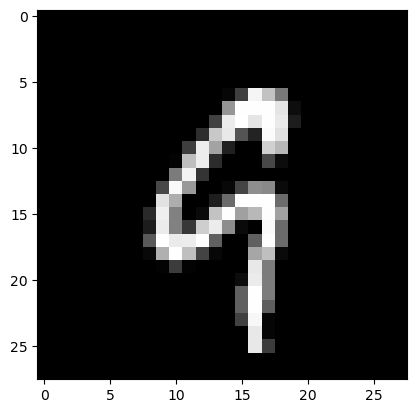

In [14]:
plt.imshow(images[0].numpy().squeeze(), cmap = 'gray')

定义神经网络

In [26]:
class NerualNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        '''
        第一个线性层
        输入图片28 * 28
        输出未第一个隐层的输入，为128
        '''
        
        self.linear1 = nn.Linear(28 * 28, 128)
        self.relu1 = nn.ReLU()
        
        '''
        第二个线性层
        输入为第一个隐层的输出
        输出为第二个隐层的输入，为64
        '''
        
        self.linear2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        
        '''
        第三个线性层
        输入为第二个隐层的输出
        输出为输出层的输入，为10
        '''
        
        self.linear3 = nn.Linear(64, 10)
        # 最终通过softmax进行归一化
        self.softmax = nn.Softmax(dim = 1)
        
        '''
        上述均可使用nn.Sequential()进行简化
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim = 1)
            )
        '''
    def forward(self, x):
        '''
        定义神经网络的前向传播
        X:图片数据，shape为（64，1，28，28）
        '''
        # 将x的shape从(64, 1, 28, 28)变为(64, 28 * 28)
        x = x.view(x.shape[0], -1)
        
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.softmax(x)
        # 上述可以直接用x = self.model(x)代替
        return x

In [27]:
model = NerualNetwork()

定义损失函数和优化器

In [28]:
criterion = nn.NLLLoss()

In [29]:
optimizer = optim.SGD(model.parameters(), lr = 0.003, momentum = 0.9)

训练模型

In [30]:
time0 = time()# 记录开始时间
epochs = 15
for e in range(epochs):
    running_loss = 0 # 本轮的损失
    for images, labels in train_loader:
        output = model(images) # 前向传播获取预测值
        loss = criterion(output, labels) # 计算损失
        loss.backward() # 反向传播计算梯度
        optimizer.step() # 优化器更新权重
        optimizer.zero_grad() # 优化器梯度归零
        running_loss += loss.item() # 累加损失
    else:
        # 每轮结束后打印损失
        print('Epoch {} - Training loss: {}'.format(e, running_loss / len(train_loader)))
#打印总的训练时间
print('\nTrainning Time (in minutes) =', (time() - time0) / 60)

Epoch 0 - Training loss: -0.2783155512612766
Epoch 1 - Training loss: -0.6030978545514759
Epoch 2 - Training loss: -0.7410943994262834
Epoch 3 - Training loss: -0.8140240294465633
Epoch 4 - Training loss: -0.8271245513516449
Epoch 5 - Training loss: -0.833569277197059
Epoch 6 - Training loss: -0.8383102209837452
Epoch 7 - Training loss: -0.8418217843402424
Epoch 8 - Training loss: -0.844900639707854
Epoch 9 - Training loss: -0.8469466582290145
Epoch 10 - Training loss: -0.8492770357045538
Epoch 11 - Training loss: -0.8512311397966291
Epoch 12 - Training loss: -0.8531362842013841
Epoch 13 - Training loss: -0.854507542304647
Epoch 14 - Training loss: -0.8559040154602482

Trainning Time (in minutes) = 2.490699625015259


评估模型

In [31]:
correct_count, all_count = 0, 0
model.eval()# 切换到评估模式

# 从test_loader中取出一批图片进行测试
for images, labels in test_loader:
    # 循环检测这批图片
    for i in range(len(labels)):
        logps = model(images[i]) # 前向传播获取预测值
        probab = list(logps.detach().numpy()[0]) # 取出预测值转化为列表
        pred_label = probab.index(max(probab)) # 取最大值的索引作为预测结果
        true_label = labels.numpy()[i]
        if(true_label == pred_label): # 判断是否预测正确
            correct_count += 1
        all_count += 1
print('Number of Images Tested = ', all_count)
print('\nModel Accuracy =', (correct_count / all_count))

Number of Images Tested =  10000

Model Accuracy = 0.8615
